In [1]:
# !pip3 uninstall Pillow -y
# !pip3 install Pillow
# !pip uninstall Pillow -y
# !pip install Pillow

In [2]:
"""
AFTER YOU RUN THIS CELL MAKE SURE
YOU RESTART RUNTIME COLAB AND
RUN IT AGAIN FROM FIRST CELL
"""

# Download all packages
from google.colab import files, output

!rm -rf vortex
!git clone https://github.com/nodefluxio/vortex.git
!cp -r vortex/examples/detr/module ./
!cp vortex/examples/detr/config.yml ./
!cd vortex && git checkout drop-enforce && pip install --ignore-installed --timeout=10000 ./src/development
!cd vortex && pip install --ignore-installed --timeout=10000 ./src/runtime[onnxruntime]
!pip install torchtext==0.7
!pip install --force-reinstall tqdm==4.49
!rm -rf vortex

output.clear()
print("Pakcages installed!")

Pakcages installed!


In [73]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import os
import sys
import cv2
import yaml
import onnx
import torch
import argparse
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F
import vortex.runtime.onnx.graph_ops.embed_model_property as g
from PIL import Image
from copy import copy
from pathlib import Path
from torch import nn, optim
from easydict import EasyDict
from module.utils import collate_fn
from module.model import build_model
from vortex.runtime.helper import InferenceHelper
from pytorch_lightning.callbacks import EarlyStopping
from vortex.development.networks.models import ModelBase
from module.dataset import build_dataset, BetterCOCO, COCODetection, VOCDetection, CocoEvaluator

print("All packages loaded!")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
All packages loaded!


In [4]:
# Upload API files from kaggle
!rm kaggle.json

files.upload()
output.clear()
print("Files uploaded!")

Files uploaded!


In [5]:
# Connect colab to kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

output.clear()
print("Collab connected to Kaggle!")

Collab connected to Kaggle!


In [6]:
# Setup datasets
!rm -rf Yolo-to-COCO-format-converter
!git clone https://github.com/Taeyoung96/Yolo-to-COCO-format-converter.git
!rm Yolo-to-COCO-format-converter/tutorial/train/*
!rm Yolo-to-COCO-format-converter/output/*
!echo Weapon > Yolo-to-COCO-format-converter/tutorial/obj.names

!rm weapons-in-images-segmented-videos.zip
!kaggle datasets download -d jubaerad/weapons-in-images-segmented-videos
!rm -rf Weapons-in-Images
!unzip weapons-in-images-segmented-videos.zip
!rm weapons-in-images-segmented-videos.zip
!rm -rf "Weapon in Images (Segmented Video)"
!mv Weapons-in-Images/Weapons-in-Images/* Yolo-to-COCO-format-converter/tutorial/train/
!rm -rf Weapons-in-Images

all_data_weapons = os.listdir("./Yolo-to-COCO-format-converter/tutorial/train")
for data in all_data_weapons:
    real_data, extension_data = data.split(".")
    if extension_data == "jpg" and f"{real_data}.txt" not in all_data_weapons:
        os.remove(f"./Yolo-to-COCO-format-converter/tutorial/train/{data}")

!rm Yolo-to-COCO-format-converter/tutorial/train.txt
image_files = []
os.chdir("Yolo-to-COCO-format-converter/tutorial/train")
for filename in os.listdir(os.getcwd()):
    if filename.endswith(".jpg"):
        image_files.append("/content/Yolo-to-COCO-format-converter/tutorial/train/" + filename)
os.chdir("..")
with open("train.txt", "w") as outfile:
    for image in image_files:
        outfile.write(image)
        outfile.write("\n")
    outfile.close()
os.chdir("/content/")

output.clear()
print("Datasets downloaded!")

Datasets downloaded!


In [7]:
"""
1. EDIT YOUR OWN CLASSES IN Yolo-to-COCO-format-converter/main.py
2. EDIT config.yml TO COCO DATASETS, MAKE SURE SETTING THE ARGS
3. UPLOAD YOUR TEST IMAGES
"""
assert False

AssertionError: ignored

In [8]:
# Change yolo to coco datasets
!cd Yolo-to-COCO-format-converter && python main.py --path /content/Yolo-to-COCO-format-converter/tutorial/train.txt \
--output train

output.clear()
print("Datasets changed to coco format!")

Datasets changed to coco format!


In [9]:
# Create new directory for coco datasets format
!rm -rf datasets
!mkdir -p datasets/{data,annotations}
!mv Yolo-to-COCO-format-converter/output/train.json datasets/annotations/annotations.json
!mv Yolo-to-COCO-format-converter/tutorial/train/*.jpg datasets/data
!rm -rf Yolo-to-COCO-format-converter

output.clear()
print("Created new directory for coco datasets format!")

Created new directory for coco datasets format!


In [74]:
# Set up vortex
class SuppressedPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

class DataLoader(pl.LightningDataModule):
    def __init__(self, args: dict):
        super().__init__()
        self.args = args['dataset']
        self.loader_args = args['dataloader']
        self.prepare_data()
    
    def prepare_data(self):
        if not hasattr(self, 'train_dataset'):
            self._init_train_set()
        if not hasattr(self, 'val_dataset'):
            self._init_val_set()

    def _init_train_set(self):
        args = self.args
        args['args'].update({'image_set': 'train'})
        self.train_dataset = build_dataset(**args)
        if isinstance(self.train_dataset, VOCDetection):
            self.num_classes = 2
        elif isinstance(self.train_dataset, COCODetection):
            self.num_classes = 2

    def train_dataloader(self):
        kwargs = self.loader_args
        kwargs.update({'collate_fn': collate_fn})
        return torch.utils.data.DataLoader(self.train_dataset, **kwargs)
    
    def _init_val_set(self):
        args = self.args
        args['args'].update({'image_set': 'train'})
        self.val_dataset = build_dataset(**args)
        if isinstance(self.val_dataset, VOCDetection):
            filename = Path('tmp/coco_fmt.json')
            filename.parent.mkdir(exist_ok=True, parents=True)
            self.val_dataset.to_coco(filename=filename)
            self.val_coco_fmt = BetterCOCO(filename)
        else:
            filename = args['args']['ann_file']
            root = args['args']['img_folder']
            self.val_coco_fmt = BetterCOCO(filename, root=root)

    def val_dataloader(self):
        kwargs = copy(self.loader_args)
        kwargs.update(dict(
            collate_fn=collate_fn,
            shuffle=False
        ))
        return torch.utils.data.DataLoader(self.val_dataset, **kwargs)

class DETR(ModelBase):
    def __init__(self, args: dict, gt=None):
        super().__init__()
        args.setdefault('device', self.device)
        args.setdefault('num_classes', 2)
        args = EasyDict(args)
        self.args = args
        model, criterion, postprocessors = build_model(args)
        self.model = model
        self.criterion = criterion
        self.postprocessors = postprocessors
        self.init_evaluator(gt)
    
    def init_evaluator(self, gt=None):
        self.gt = gt
        self.coco_evaluator = CocoEvaluator(self.gt, ['bbox']) \
            if self.gt else None

    def available_metrics(self):
        return None

    def output_format(self):
        return {}

    def predict(self, *args, **kwargs):
        return self.model(*args,**kwargs)
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss_dict = self.criterion(y_hat, y)
        weight_dict = self.criterion.weight_dict
        loss = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        self.log('train_loss', loss.detach(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, targets = batch
        outputs = self(x)
        loss_dict = self.criterion(outputs, targets)
        weight_dict = self.criterion.weight_dict
        loss = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        self.log('val_loss', loss.detach(), logger=True)
        if self.coco_evaluator is None:
            return
        orig_target_sizes = torch.stack([t["orig_size"] for t in targets], dim=0)
        results = self.postprocessors['bbox'](outputs, orig_target_sizes)
        if len(results) == 0:
            return
        res = {int(target['image_id']): output for target, output in zip(targets, results)}
        self.coco_evaluator.update(res)
    
    def validation_epoch_end(self, validation_step_outputs):
        coco_evaluator = self.coco_evaluator
        if coco_evaluator is not None:
            if len(coco_evaluator.eval_imgs['bbox']):
                with SuppressedPrints():
                    coco_evaluator.synchronize_between_processes()
                    coco_evaluator.accumulate()
                    coco_evaluator.summarize()
                res = coco_evaluator.coco_eval['bbox'].stats.tolist()
                params = coco_evaluator.coco_eval['bbox'].params
                iou_low, iou_high = params.iouThrs[0], params.iouThrs[-1]
                max_det_l, max_det_m, max_det_h = params.maxDets
                legends = [
                    f'(AP) @[ IoU={iou_low}:{iou_high} | area=   all | maxDets={max_det_h} ]',
                    f'(AP) @[ IoU=0.50      | area=   all | maxDets={max_det_h} ]',
                    f'(AP) @[ IoU=0.75      | area=   all | maxDets={max_det_h} ]',
                    f'(AP) @[ IoU={iou_low}:{iou_high} | area= small | maxDets={max_det_h} ]',
                    f'(AP) @[ IoU={iou_low}:{iou_high} | area=medium | maxDets={max_det_h} ]',
                    f'(AP) @[ IoU={iou_low}:{iou_high} | area= large | maxDets={max_det_h} ]',
                    f'(AR) @[ IoU={iou_low}:{iou_high} | area=   all | maxDets={max_det_l} ]',
                    f'(AR) @[ IoU={iou_low}:{iou_high} | area=   all | maxDets={max_det_m} ]',
                    f'(AR) @[ IoU={iou_low}:{iou_high} | area= small | maxDets={max_det_h} ]',
                    f'(AR) @[ IoU={iou_low}:{iou_high} | area=medium | maxDets={max_det_h} ]',
                    f'(AR) @[ IoU={iou_low}:{iou_high} | area= large | maxDets={max_det_h} ]',
                ]
                self.log_dict(dict(zip(legends,res)), on_epoch=True, prog_bar=False, logger=True)
                mAP, mAP50, mAP75 = res[:3]
            else:
                mAP, mAP50, mAP75 = 0, 0, 0
            self.log('mean AP', mAP, on_epoch=True, logger=True, prog_bar=True)
            self.log('mean AP (50)', mAP50, on_epoch=True, logger=True, prog_bar=True)
            self.log('mean AP (75)', mAP75, on_epoch=True, logger=True, prog_bar=True)
        self.init_evaluator(self.gt)
    
    def configure_optimizers(self):
        args = self.args
        model_without_ddp = self.model
        param_dicts = [
            {"params": [p for n, p in model_without_ddp.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in model_without_ddp.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": args.lr_backbone,
            },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=args.lr,
                                      weight_decay=args.weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_drop)
        return dict(
            optimizer=optimizer,
            lr_scheduler=lr_scheduler,
        )

class DETRPreprocess(nn.Module):
    __constants__ = ['mean','std','scale']
    def __init__(self):
        super().__init__()
        mean = torch.tensor([0.485, 0.456, 0.406]).reshape(-1,1,1)
        std  = torch.tensor([0.229, 0.224, 0.225]).reshape(-1,1,1)
        scale = torch.tensor([255.],dtype=torch.float32)
        self.register_buffer('mean', mean)
        self.register_buffer('std', std)
        self.register_buffer('scale', scale)
    
    def forward(self, x):
        x = torch.flip(x,[-1])
        x = x.permute(0,3,1,2)
        x = x.div(self.scale)
        x = x.sub_(self.mean).div_(self.std)
        return x

class DETRPostProcess(nn.Module):
    def __init__(self):
        super().__init__()

    def box_cxcywh_to_xyxy(self, x):
        x_c, y_c, w, h = x.unbind(1)
        b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
            (x_c + 0.5 * w), (y_c + 0.5 * h)]
        return torch.stack(b, dim=1)
    
    def forward(self, outputs, score_threshold):
        out_logits, out_bbox = outputs['pred_logits'], outputs['pred_boxes']

        prob = torch.nn.functional.softmax(out_logits, -1)
        scores, labels = prob[..., :-1].max(-1)

        keep = scores > score_threshold
        keep = keep.nonzero()[...,-1]
        out_bbox = torch.index_select(out_bbox,index=keep,dim=1)
        scores = torch.index_select(scores,index=keep,dim=1).unsqueeze(-1)
        labels = torch.index_select(labels,index=keep,dim=1).float().unsqueeze(-1)
        bboxes = self.box_cxcywh_to_xyxy(out_bbox.squeeze(0)).unsqueeze(0)
        return torch.cat((bboxes,scores,labels),-1)

class DETRInference(nn.Module):
    def __init__(self,args, torch_path=None):
        super().__init__()
        self.detr = DETR(args)
        self.preprocess  = DETRPreprocess()
        self.postprocess = DETRPostProcess()
        if torch_path is not None:
            self.detr.load_state_dict(torch.load(torch_path, map_location=torch.device('cpu')))

    def forward(self, x, score_threshold):
        x = self.preprocess(x)
        output = self.detr(x)
        x = {'pred_logits':output['pred_logits'],
             'pred_boxes' : output['pred_boxes']}
        x = self.postprocess(x,score_threshold)
        return x

output.clear()
print("Package has been set up!")

Package has been set up!


In [75]:
# Create helper function
def build_trainer(args: dict):
    args = EasyDict(args['trainer'])
    loggers = [
        pl.loggers.TensorBoardLogger('logs/'),
    ]
    callbacks = [
        EarlyStopping(monitor='train_loss', patience=5, 
                      verbose=True, mode='auto'),
    ]
    trainer = pl.Trainer(
        max_epochs=args.max_epochs, gpus=args.gpus, logger=loggers,
        check_val_every_n_epoch=args.check_val_every_n_epoch,
        callbacks=callbacks
    )
    return trainer

def load_state_dict(backbone):
    if backbone=='resnet50':
        state_dict = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu', check_hash=True)
        return state_dict

def test_image(filename, as_numpy=True):
    img = Image.open(filename)
    if as_numpy:
        img = np.array(img)
        img = np.expand_dims(img,0)
    return img

def main(args: dict, filename_torch, filename_onnx,
         test_image_source, classes, size):
    dataset = DataLoader(args)
    args.update({'num_classes': dataset.num_classes})
    model = DETR(args)
    state_dict = load_state_dict(args['backbone'])
    if state_dict is not None:
        if dataset.num_classes == 91:
            model.model.load_state_dict(state_dict['model'], strict=True)
        else:
            filtered = list(filter(lambda x: 'class_embed' not in x, state_dict['model'].keys()))
            state_dict = {key: state_dict['model'][key] for key in filtered}
            model.model.load_state_dict(state_dict, strict=False)
    trainer = build_trainer(args)
    val_gt = dataset.val_coco_fmt
    model.init_evaluator(val_gt)
    trainer.fit(model, dataset)
    torch.save(model.state_dict(), filename_torch)

    detr = DETRInference(args, filename_torch)
    detr.eval()
    img = test_image(test_image_source)
    img = cv2.resize(img[0], size[::-1])
    img = torch.from_numpy(img).unsqueeze(0)
    export_args = dict(
        input_names=["input", "score_threshold"],
        output_names=["output"],
        opset_version=11,
    )
    example_input = (img, torch.tensor([0.7]))
    torch.onnx.export(detr,example_input,filename_onnx,**export_args)
    output_format = dict(
        bounding_box=dict(
            indices=[0,1,2,3],
            axis=1,
        ),
        class_confidence=dict(
            indices=[4],
            axis=1,
        ),
        class_label=dict(
            indices=[5],
            axis=1,
        )
    )
    class_names = classes
    model_props = dict(
        output_format=output_format,
        class_names=class_names,
    )
    f = g.EmbedModelProperty(model_props)
    model = onnx.load(filename_onnx)
    model = f(model)
    onnx.save(model, filename_onnx)

def inference(filename_onnx, test_image_source):
    img = test_image(test_image_source)
    img = np.flip(img,-1)
    img = cv2.resize(img[0],size[::-1])[None,...]

    kwargs = dict(
        model_path=filename_onnx,
        runtime='cpu',
    )
    rt = InferenceHelper.create_runtime_model(**kwargs)

    kwargs = dict(
        score_threshold=0.3,
        visualize=True,
    )
    result = rt(img,**kwargs)
    print(result['prediction'])

    if 'visualization' in result:
        visual = result['visualization'][0]
        visual = np.flip(visual,2)
        plt.imshow(visual)
        plt.show()

output.clear()
print("Helper function has been set up!")

Helper function has been set up!


In [76]:
# Set Hyperparameters
size = (480, 640)
classes = ["Nan", "Weapon"]
filename_torch = "saved_model_torch.pth"
filename_onnx = "saved_model_onnx.onnx"
test_image_source = "weapon0.jpg"

output.clear()
print("Hyperparameters has been set up!")

Hyperparameters has been set up!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.35s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


EarlyStopping mode set to min for monitoring train_loss.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning:

You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type         | Params
-------------------------------------------
0 | model     | DETR         | 41.5 M
1 | criterion | SetCriterion | 0     
-------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params


/usr/local/lib/python3.7/dist-packages/torch/tensor.py:455: RuntimeWarning:

Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:201: UserWarning:

This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)



[OrderedDict([('bounding_box', None), ('class_confidence', None), ('class_label', None)])]


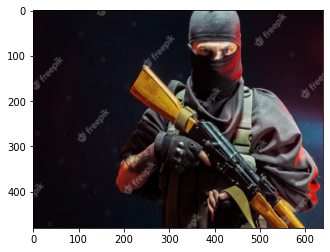

In [77]:
# Train model
if hasattr(__builtins__,'__IPYTHON__'):
    config_file = 'config.yml'
else:
    parser = argparse.ArgumentParser()
    parser.add_argument('--config',default='config.yml')
    args = parser.parse_args()
    config_file = args.config

with open(config_file) as f:
    args = yaml.load(f)

main(args, filename_torch, filename_onnx, 
     test_image_source, classes, size)
inference(filename_onnx, test_image_source)